# Ambient Air Quality in Kochi and Trivandrum

Air pollution is one of the greatest environmental risk to health, contributing to respiratory and cardiovascular diseases, cancer, and premature death. Tracking air pollution levels can help governments and policy makers make informed policies and decisions to improve public and environmental health. 

There are a few common air pollutants that are frequently monitored as a proxy to achieving good air quality in cities. <br>

<b>Particulate Matter (PM)</b>
- RSPM/PM10/PM2.5: PM is a common proxy indicator for air pollution. There is strong evidence for the negative health impacts associated with exposure to this pollutant. The major components of PM are sulfates, nitrates, ammonia, sodium chloride, black carbon, mineral dust and water. PM10 are for particles with a diameter of 10 micrometers or less, while PM2.5 are for fine particles with a diameter of 2.5 micrometers or less. These are particularly harmful as they can penetrate deep into the lungs and even enter the bloodstream.

<b>Gaseous Pollutants</b>
- SO<sub>2</sub>: SO<sub>2</sub> is a colourless gas with a sharp odour. It is produced from the burning of fossil fuels (coal and oil) and the smelting of mineral ores that contain sulfur.
- NO<sub>2</sub>: NO<sub>2</sub> is a gas that is commonly released from the combustion of fuels in the transportation and industrial sectors.

## Data

## Air Pollutant Data

The data was downloaded from www.kerala.data.gov and is available for the years 1987 to 2002 and 2005 to 2015. Data for the years 2003 and 2004 are not available. Each year is recorded in a separate downloaded EXCEL file. <br>
Each file generally included:
- The station code where the data was recorded (Stn Code)
- Date of record (Sampling Date)
- Place of record (City/Town/Village Area)
- Agency 
- Type of location
- SO<sub>2</sub> values
- NO<sub>2</sub> values
- RSPM/PM10 values
- SPM values
- PM2.5 values

The completeness of data varies by year and city.


## Methodology

Data for 27 years were concatenated and pre-processed. Columns were standardized whenever possible. However, as the recording format varies from year to year, some human errors may have occurred in the process of standardizing the data. Due to lack of data for some columns, only SO<sub>2</sub>, NO<sub>2</sub> and RSPM/PM10 values were used for analysis and visualization. It is also important to note that data quality varies across cities and years.

## A look at the data



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import base64
from io import BytesIO
import dash
from dash import dcc, html
import dash_bootstrap_components as dbc
from dash.dependencies import Input, Output
import ace as tools
from dash import jupyter_dash


#### Columns within the data (First five entries)

In [2]:
data = pd.read_csv('../data/combined_airquality_edit.csv')
data.head()

Stn Code Sampling Date  Month  Year   State City/Town/Village/Area  \
0      29.0     10/3/1987    3.0  1987  Kerala                 Cochin   
1      30.0      4/5/1988    5.0  1988  Kerala                 Cochin   
2      31.0      4/5/1988    5.0  1988  Kerala                 Cochin   
3      32.0      4/5/1988    5.0  1988  Kerala                 Cochin   
4      33.0      4/5/1988    5.0  1988  Kerala                 Cochin   

                           Agency Type of Location  SO2  NO2  RSPM/PM10   SPM  \
0  Kerala Pollution Control Board       Industrial  NaN  2.9        NaN   NaN   
1  Kerala Pollution Control Board  Industrial Area  NaN  NaN        NaN  79.0   
2  Kerala Pollution Control Board  Industrial Area  NaN  NaN        NaN  88.0   
3  Kerala Pollution Control Board  Industrial Area  NaN  NaN        NaN  98.0   
4  Kerala Pollution Control Board              NaN  NaN  NaN        NaN  88.0   

  Location of Monitoring Station  PM 2.5  
0                            NaN     NaN  
1                            NaN     NaN  
2                            NaN     NaN  
3                            NaN     NaN  
4                            NaN     NaN

#### All cities available in dataset

Some cities are duplicated (E.g. 'Cochi' and 'Kochi' are the same cities) <br>
Data preprocessing:
- Renaming duplicated cities to unified names
- Removing null values
- Standardizing date format
- Aggregating data by yearly average

In [3]:
# All the cities/regions available
data['City/Town/Village/Area'].unique().tolist()

['Cochin',
 'Kotttayam',
 'Kottayam',
 'Kozhikode',
 'Trivendrum',
 'Palakkad',
 'Kochi',
 'Trivandrum',
 'Alappuzha',
 'Kollam',
 'Malappuram',
 'Thiruvananthapuram',
 'Pathanamthitta',
 'Thissur',
 'Wayanad']

In [4]:
# Noticed above that some cities are duplicated (e.g. Cochin and Kochi are used interchangeably)
# Data preprocessing
data['City/Town/Village/Area'] = data['City/Town/Village/Area'].replace({
    'Kotttayam': 'Kottayam',
    'Trivendrum': 'Trivandrum',
    'Cochin': 'Kochi',
    'Thiruvananthapuram': 'Trivandrum'
})


In [5]:
# Filter data for Kochi and Trivandrum
filtered_data = data[data['City/Town/Village/Area'].isin(['Kochi', 'Trivandrum'])].copy()

filtered_data = filtered_data[['City/Town/Village/Area', 'Stn Code', 'Month', 'Year', 'SO2', 'NO2', 'RSPM/PM10', 'SPM', 'PM 2.5']]

# Handle missing values in 'Month' and 'Year' columns
filtered_data = filtered_data.dropna(subset=['Month', 'Year'])

# Convert 'Month' column to numeric, coercing errors to NaN
filtered_data['Month'] = pd.to_numeric(filtered_data['Month'], errors='coerce')

# Drop rows where 'Month' conversion resulted in NaN
filtered_data = filtered_data.dropna(subset=['Month'])

# Convert 'Year' column to integers
filtered_data['Year'] = filtered_data['Year'].astype(int)
filtered_data['Month'] = filtered_data['Month'].astype(int)

# Create a datetime column from 'Month' and 'Year'
filtered_data['Date'] = pd.to_datetime(filtered_data[['Year', 'Month']].assign(DAY=1))

# Filter the data for years from 2000 onwards
filtered_data = filtered_data[filtered_data['Date'].dt.year >= 2005]

# Ensure NO2, PM10, and PM2.5 are numeric
filtered_data['NO2'] = pd.to_numeric(filtered_data['NO2'], errors='coerce')
filtered_data['RSPM/PM10'] = pd.to_numeric(filtered_data['RSPM/PM10'], errors='coerce')
filtered_data['SO2'] = pd.to_numeric(filtered_data['SO2'], errors='coerce')

# Interpolate the missing values
filtered_data.set_index('Date', inplace=True)
filtered_data['NO2'] = filtered_data['NO2'].interpolate(method='time')
filtered_data['RSPM/PM10'] = filtered_data['RSPM/PM10'].interpolate(method='time')
filtered_data['SO2'] = filtered_data['SO2'].interpolate(method='time')

# Resample the data by month
filtered_data = filtered_data.groupby('City/Town/Village/Area').resample('ME').mean()

In [6]:
# Initialize the Dash app
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

#server = app.server

# App layout
app.layout = dbc.Container([
    dbc.Row([
        dbc.Col(html.H1("Air Quality Dashboard for Kochi and Trivandrum"), className="mb-2")
    ]),
    dbc.Row([
        dbc.Col(dcc.Dropdown(
            id='city-dropdown',
            options=[
                {'label': 'Kochi', 'value': 'Kochi'},
                {'label': 'Trivandrum', 'value': 'Trivandrum'}
            ],
            value='Kochi', #default city 
            clearable=False
        ), width=6)
    ]),
    dbc.Row([
        dbc.Col(dcc.Graph(id='no2-plot'), width=12)
    ]),
    dbc.Row([
        dbc.Col(dcc.Graph(id='pm10-plot'), width=12)
    ]),
    dbc.Row([
        dbc.Col(dcc.Graph(id='so2-plot'), width=12)
    ]),
])

# Callback to update plots
@app.callback(
    [Output('no2-plot', 'figure'),
     Output('pm10-plot', 'figure'),
     Output('so2-plot', 'figure')],
    [Input('city-dropdown', 'value')]
)
def update_plots(selected_city):
    city_data = filtered_data.loc[selected_city]
    
    no2_fig = {
        'data': [{'x': city_data.index, 'y': city_data['NO2'], 'type': 'line', 'name': 'NO2'}],
        'layout': {'title': f'NO2 Levels in {selected_city} (2005 Onwards)', 'yaxis': {'title': 'NO2'}, 'xaxis': {'title': 'Date'}}
    }

    pm10_fig = {
        'data': [{'x': city_data.index, 'y': city_data['RSPM/PM10'], 'type': 'line', 'name': 'PM10'}],
        'layout': {'title': f'PM10 Levels in {selected_city} (2005 Onwards)', 'yaxis': {'title': 'PM10'}, 'xaxis': {'title': 'Date'}}
    }

    so2_fig = {
        'data': [{'x': city_data.index, 'y': city_data['SO2'], 'type': 'line', 'name': 'SO2'}],
        'layout': {'title': f'SO2 Levels in {selected_city} (2005 Onwards)', 'yaxis': {'title': 'SO2'}, 'xaxis': {'title': 'Date'}}
    }

    return no2_fig, pm10_fig, so2_fig

# Run the app
app.run_server(mode="inline", debug=False)


### Observations

- Kochi has been managing PM 10 and SO<sub>2</sub> levels well, but NO<sub>2</sub> levels are on the rise, especially since mid-2015.
- Air Quality is generally worse in Trivandrum than Kochi.

## Using Machine Learning to predict air pollution levels (NO2) for future years in Kochi

### Random Forest Regressor

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict

In [8]:
data = pd.read_csv('../data/combined_airquality_edit.csv')
data.head()

Stn Code Sampling Date  Month  Year   State City/Town/Village/Area  \
0      29.0     10/3/1987    3.0  1987  Kerala                 Cochin   
1      30.0      4/5/1988    5.0  1988  Kerala                 Cochin   
2      31.0      4/5/1988    5.0  1988  Kerala                 Cochin   
3      32.0      4/5/1988    5.0  1988  Kerala                 Cochin   
4      33.0      4/5/1988    5.0  1988  Kerala                 Cochin   

                           Agency Type of Location  SO2  NO2  RSPM/PM10   SPM  \
0  Kerala Pollution Control Board       Industrial  NaN  2.9        NaN   NaN   
1  Kerala Pollution Control Board  Industrial Area  NaN  NaN        NaN  79.0   
2  Kerala Pollution Control Board  Industrial Area  NaN  NaN        NaN  88.0   
3  Kerala Pollution Control Board  Industrial Area  NaN  NaN        NaN  98.0   
4  Kerala Pollution Control Board              NaN  NaN  NaN        NaN  88.0   

  Location of Monitoring Station  PM 2.5  
0                            NaN     NaN  
1                            NaN     NaN  
2                            NaN     NaN  
3                            NaN     NaN  
4                            NaN     NaN

In [9]:
data['City/Town/Village/Area'] = data['City/Town/Village/Area'].replace({
    'Kotttayam': 'Kottayam',
    'Trivendrum': 'Trivandrum',
    'Cochin': 'Kochi',
    'Thiruvananthapuram': 'Trivandrum'
})

# Filter data for Kochi
kochi_data = data[data['City/Town/Village/Area'] == 'Kochi'].copy()

kochi_data = kochi_data[['City/Town/Village/Area', 'Month', 'Year', 'NO2']]

# Handle missing values in 'Month', 'Year', and 'NO2' columns
kochi_data = kochi_data.dropna(subset=['Month', 'Year', 'NO2'])

# Convert 'Month' column to numeric, coercing errors to NaN
kochi_data['Month'] = pd.to_numeric(kochi_data['Month'], errors='coerce')

# Drop rows where 'Month' conversion resulted in NaN
kochi_data = kochi_data.dropna(subset=['Month'])

# Convert 'Year' column to integers
kochi_data['Year'] = kochi_data['Year'].astype(int)
kochi_data['Month'] = kochi_data['Month'].astype(int)

# Create a datetime column from 'Month' and 'Year'
kochi_data['Date'] = pd.to_datetime(kochi_data[['Year', 'Month']].assign(DAY=1))

# Filter the data for years from 2005 onwards
kochi_data = kochi_data[kochi_data['Date'].dt.year >= 2005]

# Ensure NO2 is numeric
kochi_data['NO2'] = pd.to_numeric(kochi_data['NO2'], errors='coerce')

# Interpolate the missing values
kochi_data.set_index('Date', inplace=True)
kochi_data['NO2'] = kochi_data['NO2'].interpolate(method='time')

# Reset index for further processing
kochi_data.reset_index(inplace=True)
kochi_data['Year'] = kochi_data['Date'].dt.year

# Aggregate data by year
yearly_kochi_data = kochi_data.groupby('Year').agg({'NO2': 'mean'}).reset_index()

# Check the unique years in the filtered data
unique_years = yearly_kochi_data['Year'].unique()
print("Unique years in the dataset:", unique_years)

yearly_kochi_data.head()

Unique years in the dataset: [2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015]


Year        NO2
0  2005  13.807778
1  2006  10.889806
2  2007  12.219355
3  2008  14.312431
4  2009  12.916859

In [10]:
# Split data into features and target variable
X = yearly_kochi_data[['Year']]
y = yearly_kochi_data['NO2']

print("X:\n", X.head())
print("y:\n", y.head())

X:
    Year
0  2005
1  2006
2  2007
3  2008
4  2009
y:
 0    13.807778
1    10.889806
2    12.219355
3    14.312431
4    12.916859
Name: NO2, dtype: float64


In [11]:
# Train Random Forest Regressor with cross-validation
rf = RandomForestRegressor(n_estimators=100, random_state=42)
y_pred = cross_val_predict(rf, X, y, cv=5)

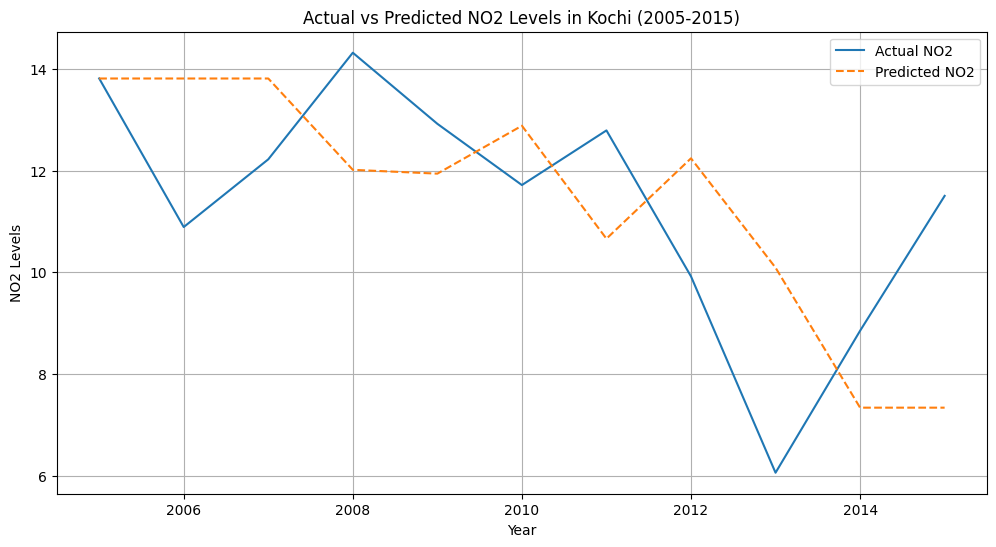

In [12]:
# Plot predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(yearly_kochi_data['Year'], y, label='Actual NO2')
plt.plot(yearly_kochi_data['Year'], y_pred, label='Predicted NO2', linestyle='--')
plt.xlabel('Year')
plt.ylabel('NO2 Levels')
plt.title('Actual vs Predicted NO2 Levels in Kochi (2005-2015)')
plt.legend()
plt.grid(True)
plt.show()

#### Model Performance

R<sub>2</sub> is a measure of how well the independent variables explain the variability of the dependent variable. It ranges from 0 to 1 (and can be negative in certain cases). <br>
RMSE is the square root of the average of the squared differences between predicted and actual values. It measures the average prediction error in the same units as the dependent variable.

In [13]:
# Evaluate the model with R-squared
r2 = r2_score(y, y_pred)
print(f'R-squared: {r2}')

# Evaluate the model with RMSE
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

R-squared: -0.13495601528962808
RMSE: 2.417655303596738


R<sub>2</sub> of -0.13495 indicates that the model if performing worse than the mean of the dependent variable. <br>
RMSE of 2.417 indicates that on average, the model's predictions deviate from the actual NO<sub>2</sub> levels by 2.417 units. 

#### Possible Reasons for Poor Performance
1. Dataset is too small, or data is too noisy.
2. Model not the best fit.
3. Feature (year) might not be sufficient, more features might be helpful.
4. Overfitting or Underfitting of data present.

#### Future work for improvements

1. Adding more features to the model (such as weather, traffic data etc.)
2. Testing a few more models and compare the results.
3. Further data preprocessing.
4. Model tuning - experimenting with different hyper parameters for the model.